In [208]:
import numpy as np

# mne imports
import mne
from mne import io
from mne.datasets import sample

# EEGNet-specific imports
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.models import Model

# PyRiemann imports
from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace
# from pyriemann.utils.viz import plot_confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

# tools for plotting confusion matrices
from matplotlib import pyplot as plt
from keras.callbacks import EarlyStopping
# while the default tensorflow ordering is 'channels_last' we set it here
# to be explicit in case if the user has changed the default ordering
K.set_image_data_format('channels_last')

In [191]:
def EEGNet(nb_classes, Chans = 64, Samples = 128, 
             dropoutRate = 0.5, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    """ Keras Implementation of EEGNet
    http://iopscience.iop.org/article/10.1088/1741-2552/aace8c/meta

    Note that this implements the newest version of EEGNet and NOT the earlier
    version (version v1 and v2 on arxiv). We strongly recommend using this
    architecture as it performs much better and has nicer properties than
    our earlier version. For example:
        
        1. Depthwise Convolutions to learn spatial filters within a 
        temporal convolution. The use of the depth_multiplier option maps 
        exactly to the number of spatial filters learned within a temporal
        filter. This matches the setup of algorithms like FBCSP which learn 
        spatial filters within each filter in a filter-bank. This also limits 
        the number of free parameters to fit when compared to a fully-connected
        convolution. 
        
        2. Separable Convolutions to learn how to optimally combine spatial
        filters across temporal bands. Separable Convolutions are Depthwise
        Convolutions followed by (1x1) Pointwise Convolutions. 
        
    
    While the original paper used Dropout, we found that SpatialDropout2D 
    sometimes produced slightly better results for classification of ERP 
    signals. However, SpatialDropout2D significantly reduced performance 
    on the Oscillatory dataset (SMR, BCI-IV Dataset 2A). We recommend using
    the default Dropout in most cases.
        
    Assumes the input signal is sampled at 128Hz. If you want to use this model
    for any other sampling rate you will need to modify the lengths of temporal
    kernels and average pooling size in blocks 1 and 2 as needed (double the 
    kernel lengths for double the sampling rate, etc). Note that we haven't 
    tested the model performance with this rule so this may not work well. 
    
    The model with default parameters gives the EEGNet-8,2 model as discussed
    in the paper. This model should do pretty well in general, although it is
	advised to do some model searching to get optimal performance on your
	particular dataset.

    We set F2 = F1 * D (number of input filters = number of output filters) for
    the SeparableConv2D layer. We haven't extensively tested other values of this
    parameter (say, F2 < F1 * D for compressed learning, and F2 > F1 * D for
    overcomplete). We believe the main parameters to focus on are F1 and D. 

    Inputs:
        
      nb_classes      : int, number of classes to classify
      Chans, Samples  : number of channels and time points in the EEG data
      dropoutRate     : dropout fraction
      kernLength      : length of temporal convolution in first layer. We found
                        that setting this to be half the sampling rate worked
                        well in practice. For the SMR dataset in particular
                        since the data was high-passed at 4Hz we used a kernel
                        length of 32.     
      F1, F2          : number of temporal filters (F1) and number of pointwise
                        filters (F2) to learn. Default: F1 = 8, F2 = F1 * D. 
      D               : number of spatial filters to learn within each temporal
                        convolution. Default: D = 2
      dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.

    """
    
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (Chans, Samples, 1))

    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (Chans, Samples, 1),
                                   use_bias = False)(input1)
    block1       = BatchNormalization()(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)
        
    flatten      = Flatten(name = 'flatten')(block2)
    
    dense        = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input1, outputs=softmax)


In [192]:
from keras.optimizers import Adam

# Create the EEGNet model
model = EEGNet(nb_classes=4, Chans=22, Samples=176, dropoutRate=0.5, kernLength=22, F1=8, D=2, F2=16, norm_rate=0.25, dropoutType='Dropout')

# Compile the model
optimizer = Adam(learning_rate=0.001)  # You can adjust the learning rate
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

print(model.summary())


Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 22, 176, 1)]      0         
                                                                 
 conv2d_11 (Conv2D)          (None, 22, 176, 8)        176       
                                                                 
 batch_normalization_29 (Ba  (None, 22, 176, 8)        32        
 tchNormalization)                                               
                                                                 
 depthwise_conv2d_9 (Depthw  (None, 1, 176, 16)        352       
 iseConv2D)                                                      
                                                                 
 batch_normalization_30 (Ba  (None, 1, 176, 16)        64        
 tchNormalization)                                               
                                                           

In [193]:
data_path = "D:\Research Dr. Power\BCI_IV_2a\BCICIV_2a_gdf"

In [194]:
raw=mne.io.read_raw_gdf("D:\Research Dr. Power\BCI_IV_2a\BCICIV_2a_gdf\A01T.gdf", eog=['EOG-left', 'EOG-central', 'EOG-right'])

raw.drop_channels(['EOG-left', 'EOG-central', 'EOG-right'])

Extracting EDF parameters from D:\Research Dr. Power\BCI_IV_2a\BCICIV_2a_gdf\A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...


C:\ProgramData\Anaconda3\envs\BCI_2\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


<RawGDF | A01T.gdf, 22 x 672528 (2690.1 s), ~26 kB, data not loaded>

In [195]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [196]:
if device == 'cuda':
    print("Running on cloud ...")
    print("Please make sure to modify how you read the data according to your need!\n\n")
    raw_data_path = "/home/bijan/projects/def-b09sdp/bijan/Phase2/"
    data_epochs = []
    data_labels = []

    for participant_id in range(1, 10):
        participant = f"P{participant_id}"
        file_path = f"{raw_data_path}/{participant}.set"
        epochs = mne.io.read_epochs_eeglab(file_path)
        data_epochs.append(epochs.get_data())
        data_labels.append(epochs.events[:, -1])

elif device == 'cpu':
    print("Running local ...")
    print("Please make sure to change the data path!\n\n")
    raw_data_path = "D:/Research Dr. Power/BCI_IV_2a/BCICIV_2a_gdf"
    train_data_epochs = []
    train_data_labels = []
    test_data_epochs = []
    test_data_labels = []
    for participant_id in range(1, 10):
        participant_E = f"A0{participant_id}E"
        participant_T = f"A0{participant_id}T"
        
        file_path_E = f"{raw_data_path}/{participant_E}.gdf"
        file_path_T = f"{raw_data_path}/{participant_T}.gdf"
        
        raw_train = mne.io.read_raw_gdf(file_path_T, eog=['EOG-left', 'EOG-central', 'EOG-right'], preload=True).drop_channels(['EOG-left', 'EOG-central', 'EOG-right'])
        raw_test = mne.io.read_raw_gdf(file_path_E, eog=['EOG-left', 'EOG-central', 'EOG-right'], preload=True).drop_channels(['EOG-left', 'EOG-central', 'EOG-right'])
        
        raw_train.set_eeg_reference()
        raw_test.set_eeg_reference()
        
        train_events = mne.events_from_annotations(raw_train)
        test_events = mne.events_from_annotations(raw_test)
        
        train_epochs = mne.Epochs(raw_train, train_events[0], event_id=[7,8,9,10], on_missing ='warn')
        test_epochs = mne.Epochs(raw_test, train_events[0], event_id=[7,8,9,10], on_missing ='warn')
        
        train_data_epochs.append(train_epochs.get_data())
        test_data_epochs.append(test_epochs.get_data())
        
        train_data_labels.append(train_epochs.events[:, -1])
        test_data_labels.append(test_epochs.events[:, -1])

Running local ...
Please make sure to change the data path!


Extracting EDF parameters from D:\Research Dr. Power\BCI_IV_2a\BCICIV_2a_gdf\A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 672527  =      0.000 ...  2690.108 secs...


C:\ProgramData\Anaconda3\envs\BCI_2\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Extracting EDF parameters from D:\Research Dr. Power\BCI_IV_2a\BCICIV_2a_gdf\A01E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 686999  =      0.000 ...  2747.996 secs...


C:\ProgramData\Anaconda3\envs\BCI_2\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']
Not setting metadata
288 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
288 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 288 events and 176 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 288 events and 176 original time points ...
0 bad epochs dropped
Extracting EDF parameters from D:\Research Dr. Power\BCI_IV_2a\BCIC

C:\ProgramData\Anaconda3\envs\BCI_2\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Extracting EDF parameters from D:\Research Dr. Power\BCI_IV_2a\BCICIV_2a_gdf\A02E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 662665  =      0.000 ...  2650.660 secs...


C:\ProgramData\Anaconda3\envs\BCI_2\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']
Not setting metadata
288 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
288 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 288 events and 176 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 288 events and 176 original time points ...
7 bad epochs dropped
Extracting EDF parameters from D:\Research Dr. Power\BCI_IV_2a\BCIC

C:\ProgramData\Anaconda3\envs\BCI_2\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Extracting EDF parameters from D:\Research Dr. Power\BCI_IV_2a\BCICIV_2a_gdf\A03E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 648774  =      0.000 ...  2595.096 secs...


C:\ProgramData\Anaconda3\envs\BCI_2\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']
Not setting metadata
288 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
288 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 288 events and 176 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 288 events and 176 original time points ...
6 bad epochs dropped
Extracting EDF parameters from D:\Research Dr. Power\BCI_IV_2a\BCIC

C:\ProgramData\Anaconda3\envs\BCI_2\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Extracting EDF parameters from D:\Research Dr. Power\BCI_IV_2a\BCICIV_2a_gdf\A04E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 660046  =      0.000 ...  2640.184 secs...


C:\ProgramData\Anaconda3\envs\BCI_2\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['1023', '1072', '32766', '768', '769', '770', '771', '772']
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']
Not setting metadata
144 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
144 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 144 events and 176 original time points ...


C:\Users\bijan\AppData\Local\Temp\ipykernel_5280\2369254686.py:39: RuntimeWarning: No matching events found for 9 (event id 9)
  train_epochs = mne.Epochs(raw_train, train_events[0], event_id=[7,8,9,10], on_missing ='warn')
C:\Users\bijan\AppData\Local\Temp\ipykernel_5280\2369254686.py:39: RuntimeWarning: No matching events found for 10 (event id 10)
  train_epochs = mne.Epochs(raw_train, train_events[0], event_id=[7,8,9,10], on_missing ='warn')
C:\Users\bijan\AppData\Local\Temp\ipykernel_5280\2369254686.py:40: RuntimeWarning: No matching events found for 9 (event id 9)
  test_epochs = mne.Epochs(raw_test, train_events[0], event_id=[7,8,9,10], on_missing ='warn')
C:\Users\bijan\AppData\Local\Temp\ipykernel_5280\2369254686.py:40: RuntimeWarning: No matching events found for 10 (event id 10)
  test_epochs = mne.Epochs(raw_test, train_events[0], event_id=[7,8,9,10], on_missing ='warn')


0 bad epochs dropped
Using data from preloaded Raw for 144 events and 176 original time points ...
0 bad epochs dropped
Extracting EDF parameters from D:\Research Dr. Power\BCI_IV_2a\BCICIV_2a_gdf\A05T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 686119  =      0.000 ...  2744.476 secs...


C:\ProgramData\Anaconda3\envs\BCI_2\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Extracting EDF parameters from D:\Research Dr. Power\BCI_IV_2a\BCICIV_2a_gdf\A05E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 679862  =      0.000 ...  2719.448 secs...


C:\ProgramData\Anaconda3\envs\BCI_2\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']
Not setting metadata
288 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
288 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 288 events and 176 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 288 events and 176 original time points ...
3 bad epochs dropped
Extracting EDF parameters from D:\Research Dr. Power\BCI_IV_2a\BCIC

C:\ProgramData\Anaconda3\envs\BCI_2\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Extracting EDF parameters from D:\Research Dr. Power\BCI_IV_2a\BCICIV_2a_gdf\A06E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 666372  =      0.000 ...  2665.488 secs...


C:\ProgramData\Anaconda3\envs\BCI_2\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']
Not setting metadata
288 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
288 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 288 events and 176 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 288 events and 176 original time points ...
6 bad epochs dropped
Extracting EDF parameters from D:\Research Dr. Power\BCI_IV_2a\BCIC

C:\ProgramData\Anaconda3\envs\BCI_2\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Extracting EDF parameters from D:\Research Dr. Power\BCI_IV_2a\BCICIV_2a_gdf\A07E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 673134  =      0.000 ...  2692.536 secs...


C:\ProgramData\Anaconda3\envs\BCI_2\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']
Not setting metadata
288 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
288 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 288 events and 176 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 288 events and 176 original time points ...
4 bad epochs dropped
Extracting EDF parameters from D:\Research Dr. Power\BCI_IV_2a\BCIC

C:\ProgramData\Anaconda3\envs\BCI_2\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Extracting EDF parameters from D:\Research Dr. Power\BCI_IV_2a\BCICIV_2a_gdf\A08E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 687791  =      0.000 ...  2751.164 secs...


C:\ProgramData\Anaconda3\envs\BCI_2\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']
Not setting metadata
288 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
288 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 288 events and 176 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 288 events and 176 original time points ...
0 bad epochs dropped
Extracting EDF parameters from D:\Research Dr. Power\BCI_IV_2a\BCIC

C:\ProgramData\Anaconda3\envs\BCI_2\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Extracting EDF parameters from D:\Research Dr. Power\BCI_IV_2a\BCICIV_2a_gdf\A09E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 675097  =      0.000 ...  2700.388 secs...


C:\ProgramData\Anaconda3\envs\BCI_2\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']
Not setting metadata
288 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
288 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 288 events and 176 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 288 events and 176 original time points ...
0 bad epochs dropped


In [197]:
train_events[0]

array([[     0,      0,      5],
       [     0,      0,      3],
       [ 30878,      0,      5],
       ...,
       [669791,      0,      8],
       [671350,      0,      6],
       [671850,      0,      9]])

In [198]:
train_events[1]

{'1023': 1,
 '1072': 2,
 '276': 3,
 '277': 4,
 '32766': 5,
 '768': 6,
 '769': 7,
 '770': 8,
 '771': 9,
 '772': 10}

In [199]:
for i in range(9):
    
    train_data_epochs[i] = train_data_epochs[i][:, :, :, np.newaxis]
    test_data_epochs[i] = test_data_epochs[i][:, :, :, np.newaxis]

In [200]:
for i in range(9):
    print("Subject {} train epochs:    ".format(i+1), train_data_epochs[i].shape, "    Subject {} train labels:    ".format(i+1), train_data_labels[i].shape)
    print("Subject {} test epochs:     ".format(i+1), test_data_epochs[i].shape, "    Subject {} test labels:     ".format(i+1), test_data_labels[i].shape)

Subject 1 train epochs:     (288, 22, 176, 1)     Subject 1 train labels:     (288,)
Subject 1 test epochs:      (288, 22, 176, 1)     Subject 1 test labels:      (288,)
Subject 2 train epochs:     (288, 22, 176, 1)     Subject 2 train labels:     (288,)
Subject 2 test epochs:      (281, 22, 176, 1)     Subject 2 test labels:      (281,)
Subject 3 train epochs:     (288, 22, 176, 1)     Subject 3 train labels:     (288,)
Subject 3 test epochs:      (282, 22, 176, 1)     Subject 3 test labels:      (282,)
Subject 4 train epochs:     (144, 22, 176, 1)     Subject 4 train labels:     (144,)
Subject 4 test epochs:      (144, 22, 176, 1)     Subject 4 test labels:      (144,)
Subject 5 train epochs:     (288, 22, 176, 1)     Subject 5 train labels:     (288,)
Subject 5 test epochs:      (285, 22, 176, 1)     Subject 5 test labels:      (285,)
Subject 6 train epochs:     (288, 22, 176, 1)     Subject 6 train labels:     (288,)
Subject 6 test epochs:      (282, 22, 176, 1)     Subject 6 test 

In [201]:
all_data_epochs = np.zeros(len(train_data_epochs)).tolist()
all_data_labels = np.zeros(len(train_data_epochs)).tolist()

for i in range(len(train_data_epochs)):
    all_data_epochs[i] = np.concatenate((train_data_epochs[i], test_data_epochs[i]), axis=0)
    all_data_labels[i] = np.concatenate((train_data_labels[i], test_data_labels[i]), axis=0)

In [202]:
# Checking if the concatenation does not have a problem!

print("Specific element in train and test sets:      ", train_data_epochs[i][10, 10, 10], test_data_epochs[i][100, 13, 14])
print("The same element in all data set combined:    ", all_data_epochs[i][10, 10, 10], all_data_epochs[i][388, 13, 14])
print("\n\n")
print("Checking the labels in train and test:        ", train_data_labels[i][10], test_data_labels[i][100])
print("The same element in all data set combined:    ", all_data_labels[i][10], all_data_labels[i][388])

Specific element in train and test sets:       [1.83144636e-06] [4.31228067e-06]
The same element in all data set combined:     [1.83144636e-06] [4.31228067e-06]



Checking the labels in train and test:         7 8
The same element in all data set combined:     7 8


In [203]:
for i in range(len(all_data_epochs)):
    print("All data epoch shape (sub {}):    ".format(i), all_data_epochs[i].shape, "    All label shape (sub {}):     ".format(i), all_data_labels[i].shape)
    

All data epoch shape (sub 0):     (576, 22, 176, 1)     All label shape (sub 0):      (576,)
All data epoch shape (sub 1):     (569, 22, 176, 1)     All label shape (sub 1):      (569,)
All data epoch shape (sub 2):     (570, 22, 176, 1)     All label shape (sub 2):      (570,)
All data epoch shape (sub 3):     (288, 22, 176, 1)     All label shape (sub 3):      (288,)
All data epoch shape (sub 4):     (573, 22, 176, 1)     All label shape (sub 4):      (573,)
All data epoch shape (sub 5):     (570, 22, 176, 1)     All label shape (sub 5):      (570,)
All data epoch shape (sub 6):     (572, 22, 176, 1)     All label shape (sub 6):      (572,)
All data epoch shape (sub 7):     (576, 22, 176, 1)     All label shape (sub 7):      (576,)
All data epoch shape (sub 8):     (576, 22, 176, 1)     All label shape (sub 8):      (576,)


In [204]:
def encoder(y_data, method=OneHotEncoder):
    
    encoder = OneHotEncoder()
    encoder.fit(y_data[0].reshape(-1, 1))
    
    for i in range(len(y_data)):
        
        a = encoder.transform(y_data[i].reshape(-1, 1))
        y_data[i] = a.toarray()

    return y_data

In [205]:
no_encode = copy.deepcopy(all_data_labels)
encoded = encoder(all_data_labels)


In [206]:
print("Epochs Length:", len(all_data_labels))
print("labels Length:", len(encoded))
print('\n\n')
print("Participant 16 - Epochs[0] shape:", no_encode[0].shape)
print("Participant 16 - labels[0] shape:", encoded[0].shape)
print('\n\n')
print("Participant 16 - labels[0]:")
print(all_data_labels[0])

Epochs Length: 9
labels Length: 9



Participant 16 - Epochs[0] shape: (576,)
Participant 16 - labels[0] shape: (576, 4)



Participant 16 - labels[0]:
[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 ...
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]


In [224]:
a = []
b = [7, 8, 0.9899, 97, 34]

a.extend(b)

In [225]:
a

[7, 8, 0.9899, 97, 34]

# Cross-subject

Outer Loop 1 

      Train epochs' shape:                                (4297, 22, 176, 1)
      Test epochs' shape:                                 (573, 22, 176, 1)
      Test labels' shape:                                 (573, 4)
      Train labels' shape (without encoding):             (4297,)
      Test labels' shape (without encoding):              (573,)
      Train index:                                        [1, 2, 3, 4, 6, 7, 8, 9]
      Test index:                                         [5]



Epoch 1/500
135/135 [==============================] - 6s 36ms/step - loss: 1.3848 - accuracy: 0.2672 - val_loss: 1.3866 - val_accuracy: 0.2513
Epoch 2/500
135/135 [==============================] - 4s 33ms/step - loss: 1.3847 - accuracy: 0.2644 - val_loss: 1.3868 - val_accuracy: 0.2513
Epoch 3/500
135/135 [==============================] - 4s 33ms/step - loss: 1.3776 - accuracy: 0.2800 - val_loss: 1.3871 - val_accuracy: 0.2513
Epoch 4/500
135/135 [==============================] -

135/135 [==============================] - 6s 41ms/step - loss: 1.3047 - accuracy: 0.3884 - val_loss: 1.5153 - val_accuracy: 0.2496
Epoch 55/500
135/135 [==============================] - 6s 42ms/step - loss: 1.3045 - accuracy: 0.3882 - val_loss: 1.3721 - val_accuracy: 0.3368
Epoch 56/500
135/135 [==============================] - 5s 40ms/step - loss: 1.3066 - accuracy: 0.3782 - val_loss: 1.7932 - val_accuracy: 0.2740
Epoch 57/500
135/135 [==============================] - 6s 41ms/step - loss: 1.3099 - accuracy: 0.3824 - val_loss: 1.3935 - val_accuracy: 0.2914
Epoch 58/500
135/135 [==============================] - 5s 40ms/step - loss: 1.3058 - accuracy: 0.3833 - val_loss: 1.3764 - val_accuracy: 0.3229
Epoch 59/500
135/135 [==============================] - 5s 36ms/step - loss: 1.3021 - accuracy: 0.3879 - val_loss: 1.3524 - val_accuracy: 0.3054
Epoch 60/500
135/135 [==============================] - 5s 34ms/step - loss: 1.3031 - accuracy: 0.3893 - val_loss: 1.4229 - val_accuracy: 0.307

135/135 [==============================] - 5s 34ms/step - loss: 1.2910 - accuracy: 0.4019 - val_loss: 1.4623 - val_accuracy: 0.3054
Epoch 111/500
135/135 [==============================] - 5s 34ms/step - loss: 1.2883 - accuracy: 0.4049 - val_loss: 1.5644 - val_accuracy: 0.2810
Epoch 112/500
135/135 [==============================] - 5s 38ms/step - loss: 1.2889 - accuracy: 0.3993 - val_loss: 1.4330 - val_accuracy: 0.3141
Epoch 113/500
135/135 [==============================] - 5s 38ms/step - loss: 1.2917 - accuracy: 0.3940 - val_loss: 1.4107 - val_accuracy: 0.3054
Epoch 114/500
135/135 [==============================] - 5s 41ms/step - loss: 1.2965 - accuracy: 0.4049 - val_loss: 1.4243 - val_accuracy: 0.2705
Epoch 115/500
135/135 [==============================] - 6s 44ms/step - loss: 1.2917 - accuracy: 0.3935 - val_loss: 1.4321 - val_accuracy: 0.2688
Epoch 116/500
135/135 [==============================] - 6s 41ms/step - loss: 1.2889 - accuracy: 0.4054 - val_loss: 1.4742 - val_accuracy:

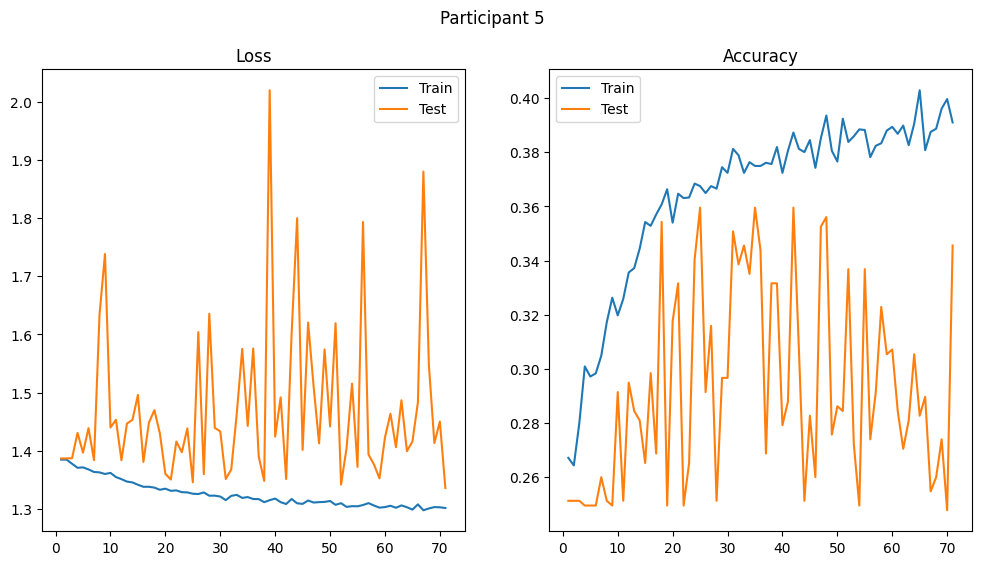

Outer Loop 2 

      Train epochs' shape:                                (4301, 22, 176, 1)
      Test epochs' shape:                                 (569, 22, 176, 1)
      Test labels' shape:                                 (569, 4)
      Train labels' shape (without encoding):             (4301,)
      Test labels' shape (without encoding):              (569,)
      Train index:                                        [1, 3, 4, 5, 6, 7, 8, 9]
      Test index:                                         [2]



Epoch 1/500
135/135 [==============================] - 8s 50ms/step - loss: 1.3853 - accuracy: 0.2688 - val_loss: 1.3865 - val_accuracy: 0.2513
Epoch 2/500
135/135 [==============================] - 7s 51ms/step - loss: 1.3818 - accuracy: 0.2825 - val_loss: 1.3866 - val_accuracy: 0.2531
Epoch 3/500
135/135 [==============================] - 7s 55ms/step - loss: 1.3773 - accuracy: 0.2937 - val_loss: 1.3884 - val_accuracy: 0.2531
Epoch 4/500
135/135 [==============================] -

135/135 [==============================] - 5s 36ms/step - loss: 1.3151 - accuracy: 0.3918 - val_loss: 1.3720 - val_accuracy: 0.3005
Epoch 55/500
135/135 [==============================] - 5s 38ms/step - loss: 1.3160 - accuracy: 0.3822 - val_loss: 1.3668 - val_accuracy: 0.2812
Epoch 56/500
135/135 [==============================] - 5s 39ms/step - loss: 1.3074 - accuracy: 0.3853 - val_loss: 1.5243 - val_accuracy: 0.2531
Epoch 57/500
135/135 [==============================] - 5s 40ms/step - loss: 1.3087 - accuracy: 0.3827 - val_loss: 1.4230 - val_accuracy: 0.2513
Epoch 58/500
135/135 [==============================] - 6s 41ms/step - loss: 1.3085 - accuracy: 0.3867 - val_loss: 1.3594 - val_accuracy: 0.3076
Epoch 59/500
135/135 [==============================] - 5s 40ms/step - loss: 1.3116 - accuracy: 0.3885 - val_loss: 1.3582 - val_accuracy: 0.3304
Epoch 60/500
135/135 [==============================] - 6s 41ms/step - loss: 1.3062 - accuracy: 0.3855 - val_loss: 1.4361 - val_accuracy: 0.268

135/135 [==============================] - 5s 40ms/step - loss: 1.2969 - accuracy: 0.3887 - val_loss: 1.3790 - val_accuracy: 0.2865
Epoch 111/500
135/135 [==============================] - 6s 42ms/step - loss: 1.2992 - accuracy: 0.3876 - val_loss: 1.3688 - val_accuracy: 0.2882
Epoch 112/500
135/135 [==============================] - 5s 37ms/step - loss: 1.2914 - accuracy: 0.4004 - val_loss: 1.3905 - val_accuracy: 0.2847
Epoch 113/500
135/135 [==============================] - 5s 35ms/step - loss: 1.2963 - accuracy: 0.3913 - val_loss: 1.3607 - val_accuracy: 0.3128
Epoch 114/500
135/135 [==============================] - 5s 36ms/step - loss: 1.2917 - accuracy: 0.3992 - val_loss: 1.4663 - val_accuracy: 0.2882
Epoch 115/500
135/135 [==============================] - 5s 36ms/step - loss: 1.2969 - accuracy: 0.3976 - val_loss: 1.3596 - val_accuracy: 0.3304
Epoch 116/500
135/135 [==============================] - 5s 37ms/step - loss: 1.2925 - accuracy: 0.3957 - val_loss: 1.4424 - val_accuracy:

<Figure size 640x480 with 0 Axes>

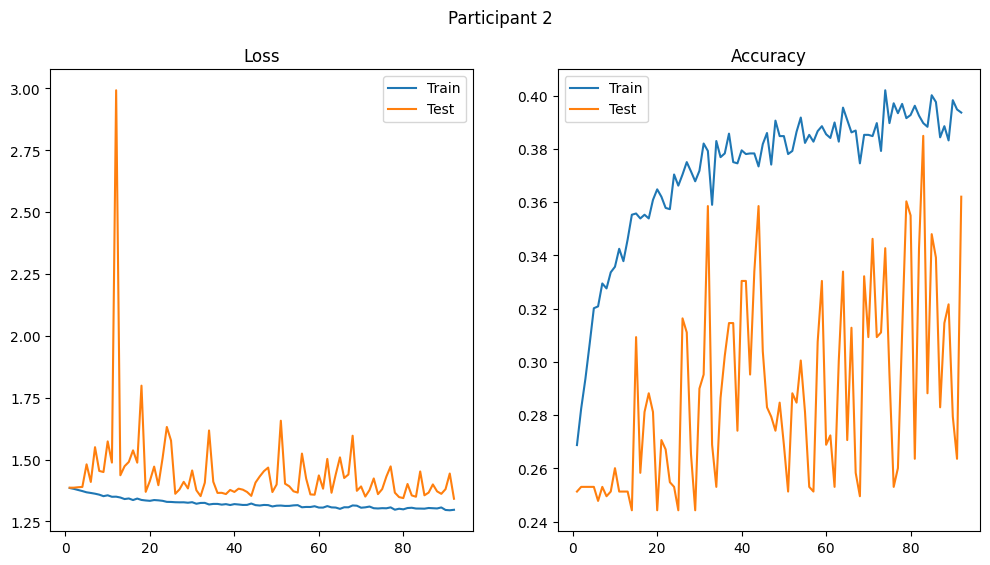

Outer Loop 3 

      Train epochs' shape:                                (4298, 22, 176, 1)
      Test epochs' shape:                                 (572, 22, 176, 1)
      Test labels' shape:                                 (572, 4)
      Train labels' shape (without encoding):             (4298,)
      Test labels' shape (without encoding):              (572,)
      Train index:                                        [1, 2, 3, 4, 5, 6, 8, 9]
      Test index:                                         [7]



Epoch 1/500
135/135 [==============================] - 9s 51ms/step - loss: 1.3851 - accuracy: 0.2601 - val_loss: 1.3865 - val_accuracy: 0.2500
Epoch 2/500
135/135 [==============================] - 7s 50ms/step - loss: 1.3841 - accuracy: 0.2659 - val_loss: 1.3869 - val_accuracy: 0.2448
Epoch 3/500
135/135 [==============================] - 7s 49ms/step - loss: 1.3810 - accuracy: 0.2766 - val_loss: 1.3864 - val_accuracy: 0.2483
Epoch 4/500
135/135 [==============================] -

135/135 [==============================] - 5s 39ms/step - loss: 1.3169 - accuracy: 0.3713 - val_loss: 1.5020 - val_accuracy: 0.3112
Epoch 55/500
135/135 [==============================] - 5s 36ms/step - loss: 1.3160 - accuracy: 0.3711 - val_loss: 1.5661 - val_accuracy: 0.3042
Epoch 56/500
135/135 [==============================] - 5s 34ms/step - loss: 1.3144 - accuracy: 0.3758 - val_loss: 1.3527 - val_accuracy: 0.3269
Epoch 57/500
135/135 [==============================] - 5s 34ms/step - loss: 1.3122 - accuracy: 0.3806 - val_loss: 1.3876 - val_accuracy: 0.3531
Epoch 58/500
135/135 [==============================] - 4s 32ms/step - loss: 1.3117 - accuracy: 0.3795 - val_loss: 1.3319 - val_accuracy: 0.3462
Epoch 59/500
135/135 [==============================] - 4s 33ms/step - loss: 1.3088 - accuracy: 0.3809 - val_loss: 1.3149 - val_accuracy: 0.3811
Epoch 60/500
135/135 [==============================] - 5s 35ms/step - loss: 1.3113 - accuracy: 0.3741 - val_loss: 1.4715 - val_accuracy: 0.292

135/135 [==============================] - 4s 33ms/step - loss: 1.3015 - accuracy: 0.3867 - val_loss: 2.6738 - val_accuracy: 0.2483
Epoch 111/500
135/135 [==============================] - 4s 33ms/step - loss: 1.3053 - accuracy: 0.3904 - val_loss: 1.5945 - val_accuracy: 0.2692
Epoch 112/500
135/135 [==============================] - 4s 33ms/step - loss: 1.3067 - accuracy: 0.3899 - val_loss: 1.4652 - val_accuracy: 0.2710
Epoch 113/500
135/135 [==============================] - 4s 33ms/step - loss: 1.3006 - accuracy: 0.3872 - val_loss: 1.8146 - val_accuracy: 0.2955
Epoch 114/500
135/135 [==============================] - 5s 34ms/step - loss: 1.2958 - accuracy: 0.3944 - val_loss: 1.8219 - val_accuracy: 0.2955
Epoch 115/500
135/135 [==============================] - 5s 35ms/step - loss: 1.2971 - accuracy: 0.3853 - val_loss: 2.1021 - val_accuracy: 0.2483
Epoch 116/500
135/135 [==============================] - 5s 39ms/step - loss: 1.2980 - accuracy: 0.3918 - val_loss: 1.5349 - val_accuracy:

<Figure size 640x480 with 0 Axes>

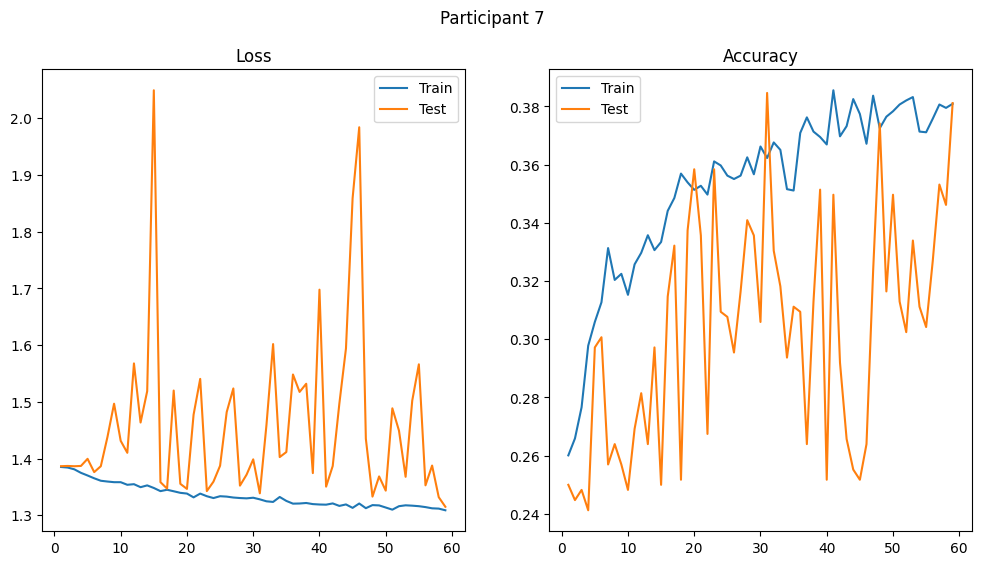

Outer Loop 4 

      Train epochs' shape:                                (4300, 22, 176, 1)
      Test epochs' shape:                                 (570, 22, 176, 1)
      Test labels' shape:                                 (570, 4)
      Train labels' shape (without encoding):             (4300,)
      Test labels' shape (without encoding):              (570,)
      Train index:                                        [1, 2, 4, 5, 6, 7, 8, 9]
      Test index:                                         [3]



Epoch 1/500
135/135 [==============================] - 6s 39ms/step - loss: 1.3848 - accuracy: 0.2684 - val_loss: 1.3867 - val_accuracy: 0.2509
Epoch 2/500
135/135 [==============================] - 5s 38ms/step - loss: 1.3834 - accuracy: 0.2779 - val_loss: 1.3874 - val_accuracy: 0.2509
Epoch 3/500
135/135 [==============================] - 5s 38ms/step - loss: 1.3804 - accuracy: 0.2719 - val_loss: 1.3868 - val_accuracy: 0.2526
Epoch 4/500
135/135 [==============================] -

135/135 [==============================] - 5s 39ms/step - loss: 1.3138 - accuracy: 0.3900 - val_loss: 1.3514 - val_accuracy: 0.3123
Epoch 55/500
135/135 [==============================] - 5s 39ms/step - loss: 1.3098 - accuracy: 0.3949 - val_loss: 1.4244 - val_accuracy: 0.2842
Epoch 56/500
135/135 [==============================] - 5s 38ms/step - loss: 1.3117 - accuracy: 0.3833 - val_loss: 1.3804 - val_accuracy: 0.3386
Epoch 57/500
135/135 [==============================] - 5s 39ms/step - loss: 1.3098 - accuracy: 0.3944 - val_loss: 1.4358 - val_accuracy: 0.3070
Epoch 58/500
135/135 [==============================] - 6s 43ms/step - loss: 1.3090 - accuracy: 0.3951 - val_loss: 1.4019 - val_accuracy: 0.2614
Epoch 59/500
135/135 [==============================] - 5s 34ms/step - loss: 1.3157 - accuracy: 0.3791 - val_loss: 1.4336 - val_accuracy: 0.3456
Epoch 60/500
135/135 [==============================] - 5s 34ms/step - loss: 1.3090 - accuracy: 0.3893 - val_loss: 1.3201 - val_accuracy: 0.364

135/135 [==============================] - 5s 39ms/step - loss: 1.2970 - accuracy: 0.4005 - val_loss: 1.3970 - val_accuracy: 0.2825
Epoch 111/500
135/135 [==============================] - 5s 40ms/step - loss: 1.2937 - accuracy: 0.4005 - val_loss: 1.3575 - val_accuracy: 0.3175
Epoch 112/500
135/135 [==============================] - 5s 38ms/step - loss: 1.3007 - accuracy: 0.3937 - val_loss: 1.3673 - val_accuracy: 0.3491
Epoch 113/500
135/135 [==============================] - 6s 41ms/step - loss: 1.2960 - accuracy: 0.3956 - val_loss: 1.3678 - val_accuracy: 0.2772
Epoch 114/500
135/135 [==============================] - 5s 38ms/step - loss: 1.2992 - accuracy: 0.3977 - val_loss: 1.4050 - val_accuracy: 0.3439
Epoch 115/500
135/135 [==============================] - 5s 38ms/step - loss: 1.2952 - accuracy: 0.3930 - val_loss: 1.3817 - val_accuracy: 0.3842
Epoch 116/500
135/135 [==============================] - 5s 39ms/step - loss: 1.2979 - accuracy: 0.3949 - val_loss: 1.4925 - val_accuracy:

<Figure size 640x480 with 0 Axes>

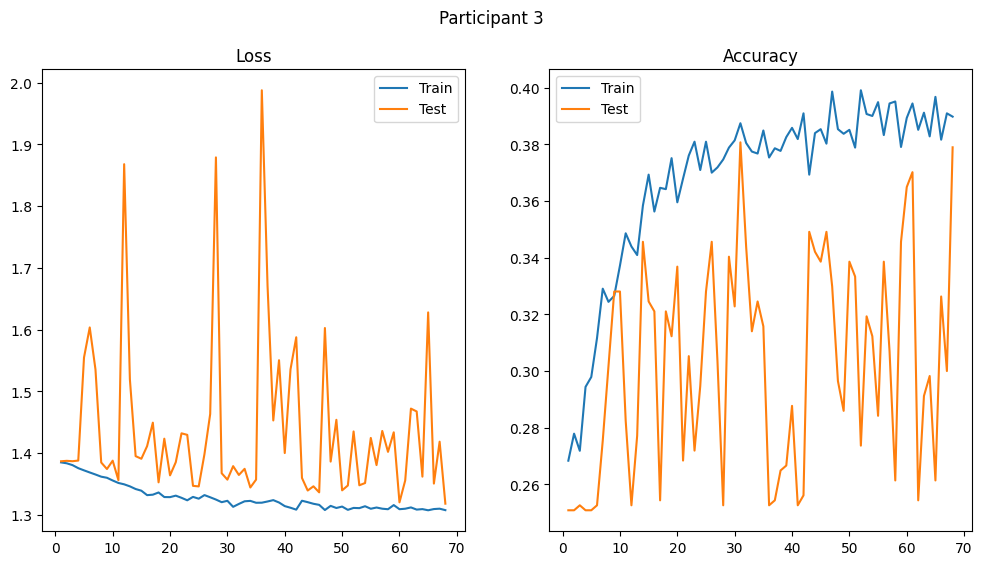

Outer Loop 5 

      Train epochs' shape:                                (4582, 22, 176, 1)
      Test epochs' shape:                                 (288, 22, 176, 1)
      Test labels' shape:                                 (288, 4)
      Train labels' shape (without encoding):             (4582,)
      Test labels' shape (without encoding):              (288,)
      Train index:                                        [1, 2, 3, 5, 6, 7, 8, 9]
      Test index:                                         [4]



Epoch 1/500
144/144 [==============================] - 7s 39ms/step - loss: 1.3863 - accuracy: 0.2457 - val_loss: 1.3855 - val_accuracy: 0.0000e+00
Epoch 2/500
144/144 [==============================] - 5s 36ms/step - loss: 1.3834 - accuracy: 0.2759 - val_loss: 1.3872 - val_accuracy: 0.4931
Epoch 3/500
144/144 [==============================] - 5s 34ms/step - loss: 1.3792 - accuracy: 0.2900 - val_loss: 1.3714 - val_accuracy: 0.5000
Epoch 4/500
144/144 [=============================

Epoch 54/500
144/144 [==============================] - 6s 39ms/step - loss: 1.3071 - accuracy: 0.3839 - val_loss: 1.5459 - val_accuracy: 0.1528
Epoch 55/500
144/144 [==============================] - 5s 37ms/step - loss: 1.3141 - accuracy: 0.3719 - val_loss: 1.5272 - val_accuracy: 0.3090
Epoch 56/500
144/144 [==============================] - 5s 37ms/step - loss: 1.3091 - accuracy: 0.3712 - val_loss: 1.3591 - val_accuracy: 0.3611
Epoch 57/500
144/144 [==============================] - 5s 37ms/step - loss: 1.3047 - accuracy: 0.3841 - val_loss: 1.9720 - val_accuracy: 0.0208
Epoch 58/500
144/144 [==============================] - 5s 34ms/step - loss: 1.3110 - accuracy: 0.3795 - val_loss: 1.5111 - val_accuracy: 0.1771
Epoch 59/500
144/144 [==============================] - 5s 32ms/step - loss: 1.3030 - accuracy: 0.3922 - val_loss: 2.5514 - val_accuracy: 0.0069
Epoch 60/500
144/144 [==============================] - 5s 33ms/step - loss: 1.3070 - accuracy: 0.3893 - val_loss: 3.2367 - val_ac

<Figure size 640x480 with 0 Axes>

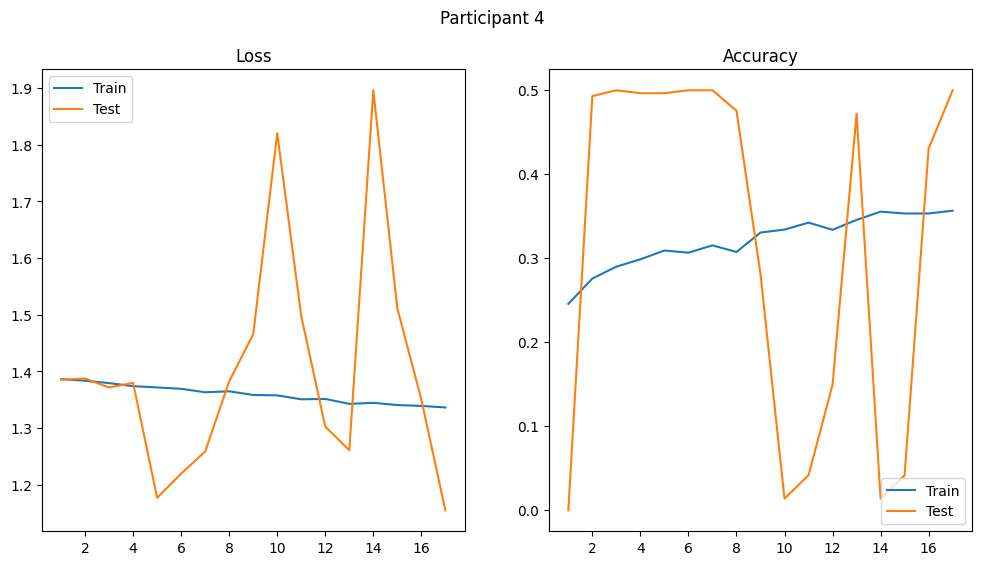

Outer Loop 6 

      Train epochs' shape:                                (4294, 22, 176, 1)
      Test epochs' shape:                                 (576, 22, 176, 1)
      Test labels' shape:                                 (576, 4)
      Train labels' shape (without encoding):             (4294,)
      Test labels' shape (without encoding):              (576,)
      Train index:                                        [2, 3, 4, 5, 6, 7, 8, 9]
      Test index:                                         [1]



Epoch 1/500
135/135 [==============================] - 6s 36ms/step - loss: 1.3852 - accuracy: 0.2664 - val_loss: 1.3868 - val_accuracy: 0.2500
Epoch 2/500
135/135 [==============================] - 5s 39ms/step - loss: 1.3803 - accuracy: 0.2823 - val_loss: 1.3870 - val_accuracy: 0.2500
Epoch 3/500
135/135 [==============================] - 5s 38ms/step - loss: 1.3726 - accuracy: 0.3037 - val_loss: 1.3911 - val_accuracy: 0.2500
Epoch 4/500
135/135 [==============================] -

135/135 [==============================] - 4s 33ms/step - loss: 1.3150 - accuracy: 0.3787 - val_loss: 1.3823 - val_accuracy: 0.2934
Epoch 55/500
135/135 [==============================] - 4s 32ms/step - loss: 1.3074 - accuracy: 0.3992 - val_loss: 1.4138 - val_accuracy: 0.2969
Epoch 56/500
135/135 [==============================] - 4s 33ms/step - loss: 1.3166 - accuracy: 0.3756 - val_loss: 1.4293 - val_accuracy: 0.2726
Epoch 57/500
135/135 [==============================] - 5s 35ms/step - loss: 1.3145 - accuracy: 0.3878 - val_loss: 1.4024 - val_accuracy: 0.3142
Epoch 58/500
135/135 [==============================] - 5s 39ms/step - loss: 1.3096 - accuracy: 0.3843 - val_loss: 1.3825 - val_accuracy: 0.2674
Epoch 59/500
135/135 [==============================] - 5s 38ms/step - loss: 1.3105 - accuracy: 0.3742 - val_loss: 1.3912 - val_accuracy: 0.2812
Epoch 60/500
135/135 [==============================] - 5s 38ms/step - loss: 1.3119 - accuracy: 0.3891 - val_loss: 1.3846 - val_accuracy: 0.291

135/135 [==============================] - 5s 36ms/step - loss: 1.2996 - accuracy: 0.3961 - val_loss: 1.4356 - val_accuracy: 0.3247
Epoch 111/500
135/135 [==============================] - 5s 34ms/step - loss: 1.2883 - accuracy: 0.3966 - val_loss: 1.3337 - val_accuracy: 0.3507
Epoch 112/500
135/135 [==============================] - 6s 46ms/step - loss: 1.2976 - accuracy: 0.4036 - val_loss: 1.3722 - val_accuracy: 0.3299
Epoch 113/500
135/135 [==============================] - 6s 43ms/step - loss: 1.2956 - accuracy: 0.3905 - val_loss: 1.7231 - val_accuracy: 0.3073
Epoch 114/500
135/135 [==============================] - 5s 39ms/step - loss: 1.2938 - accuracy: 0.3978 - val_loss: 1.3484 - val_accuracy: 0.3455
Epoch 115/500
135/135 [==============================] - 6s 43ms/step - loss: 1.2866 - accuracy: 0.4041 - val_loss: 1.5046 - val_accuracy: 0.2743
Epoch 116/500
135/135 [==============================] - 6s 42ms/step - loss: 1.2962 - accuracy: 0.3957 - val_loss: 1.3942 - val_accuracy:

135/135 [==============================] - 5s 40ms/step - loss: 1.2920 - accuracy: 0.3999 - val_loss: 1.5607 - val_accuracy: 0.2865
Epoch 167/500
135/135 [==============================] - 6s 43ms/step - loss: 1.2888 - accuracy: 0.3957 - val_loss: 1.4219 - val_accuracy: 0.3160
Epoch 168/500
135/135 [==============================] - 5s 39ms/step - loss: 1.2903 - accuracy: 0.3940 - val_loss: 1.3310 - val_accuracy: 0.3594
Epoch 169/500
135/135 [==============================] - 5s 40ms/step - loss: 1.2840 - accuracy: 0.4173 - val_loss: 1.4697 - val_accuracy: 0.3316
Epoch 170/500
135/135 [==============================] - 6s 41ms/step - loss: 1.2828 - accuracy: 0.4092 - val_loss: 1.3911 - val_accuracy: 0.3368
Epoch 171/500
135/135 [==============================] - 5s 37ms/step - loss: 1.2893 - accuracy: 0.3996 - val_loss: 1.3555 - val_accuracy: 0.3438
Epoch 172/500
135/135 [==============================] - 5s 35ms/step - loss: 1.2814 - accuracy: 0.4050 - val_loss: 1.4396 - val_accuracy:

<Figure size 640x480 with 0 Axes>

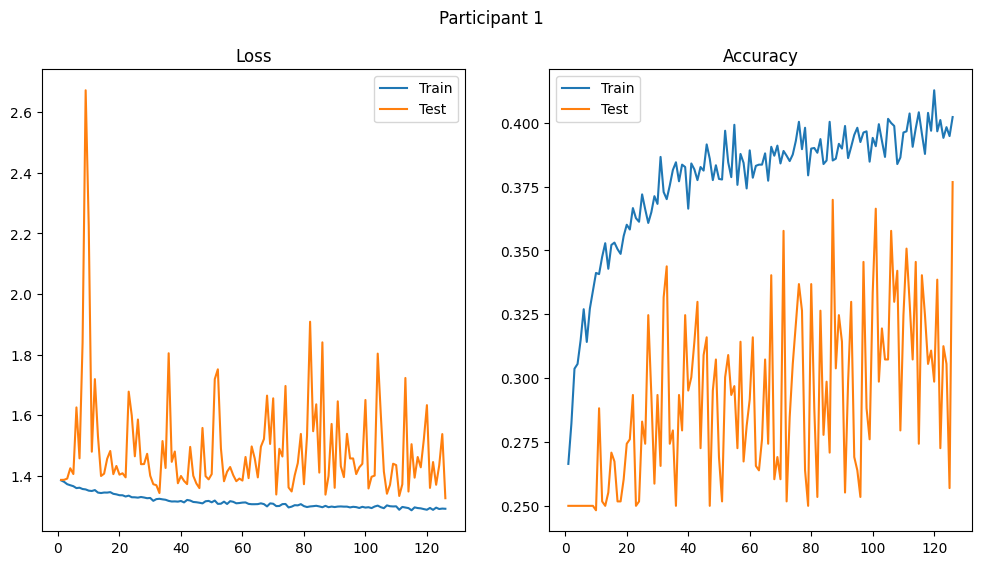

Outer Loop 7 

      Train epochs' shape:                                (4300, 22, 176, 1)
      Test epochs' shape:                                 (570, 22, 176, 1)
      Test labels' shape:                                 (570, 4)
      Train labels' shape (without encoding):             (4300,)
      Test labels' shape (without encoding):              (570,)
      Train index:                                        [1, 2, 3, 4, 5, 7, 8, 9]
      Test index:                                         [6]



Epoch 1/500
135/135 [==============================] - 6s 36ms/step - loss: 1.3847 - accuracy: 0.2663 - val_loss: 1.3867 - val_accuracy: 0.2491
Epoch 2/500
135/135 [==============================] - 5s 39ms/step - loss: 1.3831 - accuracy: 0.2784 - val_loss: 1.3869 - val_accuracy: 0.2491
Epoch 3/500
135/135 [==============================] - 5s 41ms/step - loss: 1.3756 - accuracy: 0.2921 - val_loss: 1.3904 - val_accuracy: 0.2491
Epoch 4/500
135/135 [==============================] -

135/135 [==============================] - 5s 40ms/step - loss: 1.3067 - accuracy: 0.3902 - val_loss: 1.4381 - val_accuracy: 0.2982
Epoch 55/500
135/135 [==============================] - 5s 40ms/step - loss: 1.3035 - accuracy: 0.3977 - val_loss: 1.3366 - val_accuracy: 0.3789
Epoch 56/500
135/135 [==============================] - 6s 42ms/step - loss: 1.3125 - accuracy: 0.3858 - val_loss: 1.5466 - val_accuracy: 0.2491
Epoch 57/500
135/135 [==============================] - 5s 39ms/step - loss: 1.3120 - accuracy: 0.3847 - val_loss: 1.3935 - val_accuracy: 0.3211
Epoch 58/500
135/135 [==============================] - 5s 37ms/step - loss: 1.3075 - accuracy: 0.3909 - val_loss: 1.3463 - val_accuracy: 0.3316
Epoch 59/500
135/135 [==============================] - 5s 38ms/step - loss: 1.3055 - accuracy: 0.3853 - val_loss: 1.3913 - val_accuracy: 0.2754
Epoch 60/500
135/135 [==============================] - 5s 35ms/step - loss: 1.3107 - accuracy: 0.3849 - val_loss: 1.6284 - val_accuracy: 0.266

135/135 [==============================] - 5s 38ms/step - loss: 1.2936 - accuracy: 0.3907 - val_loss: 1.7156 - val_accuracy: 0.3070
Epoch 111/500
135/135 [==============================] - 5s 36ms/step - loss: 1.2958 - accuracy: 0.3914 - val_loss: 1.4255 - val_accuracy: 0.3158
Epoch 112/500
135/135 [==============================] - 5s 34ms/step - loss: 1.2913 - accuracy: 0.3853 - val_loss: 1.3365 - val_accuracy: 0.3632
Epoch 113/500
135/135 [==============================] - 4s 33ms/step - loss: 1.2938 - accuracy: 0.4035 - val_loss: 1.3612 - val_accuracy: 0.3421
Epoch 114/500
135/135 [==============================] - 5s 34ms/step - loss: 1.2977 - accuracy: 0.3835 - val_loss: 1.3876 - val_accuracy: 0.3316
Epoch 115/500
135/135 [==============================] - 5s 34ms/step - loss: 1.2961 - accuracy: 0.3956 - val_loss: 1.3274 - val_accuracy: 0.3684
Epoch 116/500
135/135 [==============================] - 5s 35ms/step - loss: 1.2923 - accuracy: 0.4021 - val_loss: 1.3576 - val_accuracy:

<Figure size 640x480 with 0 Axes>

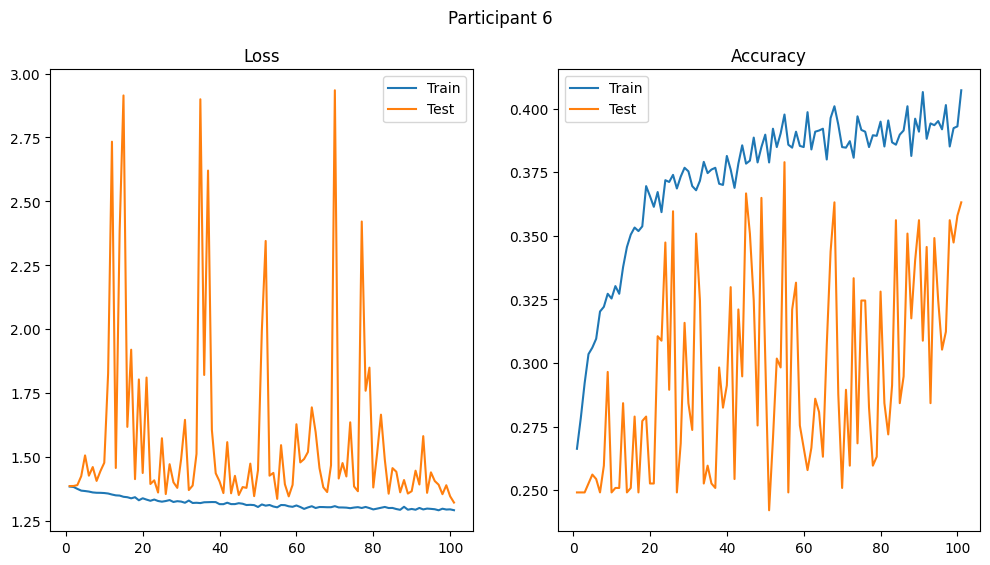

Outer Loop 8 

      Train epochs' shape:                                (4294, 22, 176, 1)
      Test epochs' shape:                                 (576, 22, 176, 1)
      Test labels' shape:                                 (576, 4)
      Train labels' shape (without encoding):             (4294,)
      Test labels' shape (without encoding):              (576,)
      Train index:                                        [1, 2, 3, 4, 5, 6, 7, 9]
      Test index:                                         [8]



Epoch 1/500
135/135 [==============================] - 8s 48ms/step - loss: 1.3847 - accuracy: 0.2662 - val_loss: 1.3866 - val_accuracy: 0.2500
Epoch 2/500
135/135 [==============================] - 8s 57ms/step - loss: 1.3821 - accuracy: 0.2823 - val_loss: 1.3868 - val_accuracy: 0.2500
Epoch 3/500
135/135 [==============================] - 5s 40ms/step - loss: 1.3790 - accuracy: 0.2881 - val_loss: 1.3874 - val_accuracy: 0.2500
Epoch 4/500
135/135 [==============================] -

135/135 [==============================] - 5s 37ms/step - loss: 1.3080 - accuracy: 0.3891 - val_loss: 1.7081 - val_accuracy: 0.2517
Epoch 55/500
135/135 [==============================] - 5s 35ms/step - loss: 1.3133 - accuracy: 0.3810 - val_loss: 1.3947 - val_accuracy: 0.3056
Epoch 56/500
135/135 [==============================] - 5s 36ms/step - loss: 1.3039 - accuracy: 0.3889 - val_loss: 1.3684 - val_accuracy: 0.3142
Epoch 57/500
135/135 [==============================] - 5s 34ms/step - loss: 1.3090 - accuracy: 0.3880 - val_loss: 1.3658 - val_accuracy: 0.3438
Epoch 58/500
135/135 [==============================] - 5s 35ms/step - loss: 1.3044 - accuracy: 0.3850 - val_loss: 1.4081 - val_accuracy: 0.3299
Epoch 59/500
135/135 [==============================] - 5s 37ms/step - loss: 1.3107 - accuracy: 0.3798 - val_loss: 1.4050 - val_accuracy: 0.2760
Epoch 60/500
135/135 [==============================] - 5s 37ms/step - loss: 1.3040 - accuracy: 0.3889 - val_loss: 1.3935 - val_accuracy: 0.305

135/135 [==============================] - 5s 34ms/step - loss: 1.2976 - accuracy: 0.3929 - val_loss: 1.5191 - val_accuracy: 0.2986
Epoch 111/500
135/135 [==============================] - 5s 36ms/step - loss: 1.2995 - accuracy: 0.3859 - val_loss: 1.3966 - val_accuracy: 0.2882
Epoch 112/500
135/135 [==============================] - 5s 39ms/step - loss: 1.2912 - accuracy: 0.4022 - val_loss: 1.4540 - val_accuracy: 0.2865
Epoch 113/500
135/135 [==============================] - 5s 39ms/step - loss: 1.2961 - accuracy: 0.3903 - val_loss: 1.3865 - val_accuracy: 0.3160
Epoch 114/500
135/135 [==============================] - 5s 40ms/step - loss: 1.2978 - accuracy: 0.3987 - val_loss: 1.4002 - val_accuracy: 0.2934
Epoch 115/500
135/135 [==============================] - 6s 42ms/step - loss: 1.2998 - accuracy: 0.3919 - val_loss: 1.4595 - val_accuracy: 0.2674
Epoch 116/500
135/135 [==============================] - 5s 40ms/step - loss: 1.2913 - accuracy: 0.4003 - val_loss: 1.3714 - val_accuracy:

135/135 [==============================] - 5s 37ms/step - loss: 1.2906 - accuracy: 0.4043 - val_loss: 1.4251 - val_accuracy: 0.2986
Epoch 167/500
135/135 [==============================] - 6s 41ms/step - loss: 1.2903 - accuracy: 0.3973 - val_loss: 1.3682 - val_accuracy: 0.3281
Epoch 168/500
135/135 [==============================] - 5s 40ms/step - loss: 1.2863 - accuracy: 0.3950 - val_loss: 1.4425 - val_accuracy: 0.3021
Epoch 169/500
135/135 [==============================] - 6s 41ms/step - loss: 1.2890 - accuracy: 0.3931 - val_loss: 1.4119 - val_accuracy: 0.2986
Epoch 170/500
135/135 [==============================] - 6s 43ms/step - loss: 1.2919 - accuracy: 0.4017 - val_loss: 1.3778 - val_accuracy: 0.3090
Epoch 171/500
135/135 [==============================] - 5s 40ms/step - loss: 1.2879 - accuracy: 0.4003 - val_loss: 1.3960 - val_accuracy: 0.3038
Epoch 172/500
135/135 [==============================] - 5s 40ms/step - loss: 1.2843 - accuracy: 0.3982 - val_loss: 1.5058 - val_accuracy:

135/135 [==============================] - 5s 38ms/step - loss: 1.2781 - accuracy: 0.4061 - val_loss: 1.5258 - val_accuracy: 0.2726
Epoch 223/500
135/135 [==============================] - 5s 35ms/step - loss: 1.2805 - accuracy: 0.4120 - val_loss: 1.3855 - val_accuracy: 0.3003
Epoch 224/500
135/135 [==============================] - 5s 33ms/step - loss: 1.2823 - accuracy: 0.3966 - val_loss: 1.4027 - val_accuracy: 0.3160
Epoch 225/500
135/135 [==============================] - 5s 35ms/step - loss: 1.2791 - accuracy: 0.4006 - val_loss: 1.4371 - val_accuracy: 0.3194
Epoch 226/500
135/135 [==============================] - 5s 35ms/step - loss: 1.2763 - accuracy: 0.4068 - val_loss: 1.8353 - val_accuracy: 0.2622
Epoch 227/500
135/135 [==============================] - 5s 35ms/step - loss: 1.2838 - accuracy: 0.4038 - val_loss: 1.3865 - val_accuracy: 0.2986
Epoch 228/500
135/135 [==============================] - 5s 38ms/step - loss: 1.2786 - accuracy: 0.4036 - val_loss: 1.3839 - val_accuracy:

<Figure size 640x480 with 0 Axes>

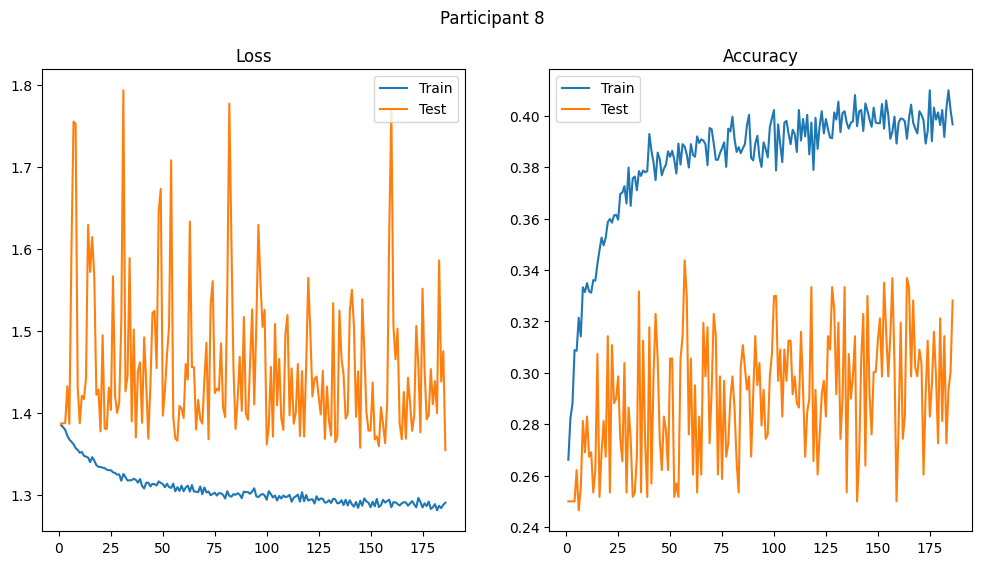

Outer Loop 9 

      Train epochs' shape:                                (4294, 22, 176, 1)
      Test epochs' shape:                                 (576, 22, 176, 1)
      Test labels' shape:                                 (576, 4)
      Train labels' shape (without encoding):             (4294,)
      Test labels' shape (without encoding):              (576,)
      Train index:                                        [1, 2, 3, 4, 5, 6, 7, 8]
      Test index:                                         [9]



Epoch 1/500
135/135 [==============================] - 6s 40ms/step - loss: 1.3854 - accuracy: 0.2531 - val_loss: 1.3868 - val_accuracy: 0.2500
Epoch 2/500
135/135 [==============================] - 5s 37ms/step - loss: 1.3835 - accuracy: 0.2613 - val_loss: 1.3869 - val_accuracy: 0.2500
Epoch 3/500
135/135 [==============================] - 5s 37ms/step - loss: 1.3792 - accuracy: 0.2785 - val_loss: 1.3870 - val_accuracy: 0.2500
Epoch 4/500
135/135 [==============================] -

135/135 [==============================] - 5s 34ms/step - loss: 1.3072 - accuracy: 0.3871 - val_loss: 1.5380 - val_accuracy: 0.2865
Epoch 55/500
135/135 [==============================] - 5s 38ms/step - loss: 1.3098 - accuracy: 0.3947 - val_loss: 1.5721 - val_accuracy: 0.3212
Epoch 56/500
135/135 [==============================] - 5s 41ms/step - loss: 1.3078 - accuracy: 0.3805 - val_loss: 1.5303 - val_accuracy: 0.3212
Epoch 57/500
135/135 [==============================] - 6s 47ms/step - loss: 1.3034 - accuracy: 0.3922 - val_loss: 1.5014 - val_accuracy: 0.3212
Epoch 58/500
135/135 [==============================] - 8s 59ms/step - loss: 1.3099 - accuracy: 0.3789 - val_loss: 1.3935 - val_accuracy: 0.3212
Epoch 59/500
135/135 [==============================] - 8s 55ms/step - loss: 1.3050 - accuracy: 0.3898 - val_loss: 1.4644 - val_accuracy: 0.3194
Epoch 60/500
135/135 [==============================] - 7s 50ms/step - loss: 1.3037 - accuracy: 0.3957 - val_loss: 1.3760 - val_accuracy: 0.336

<Figure size 640x480 with 0 Axes>

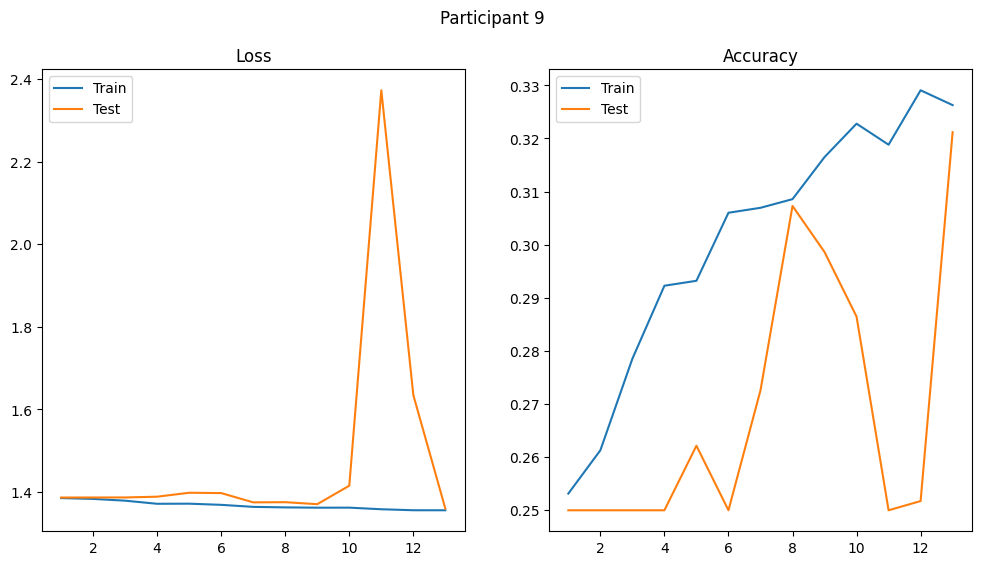

<Figure size 640x480 with 0 Axes>

In [241]:
participants = [1, 2, 3, 4, 5, 6, 7, 8, 9]
class_numbers=4
num_subjects = len(all_data_epochs)
all_tests_true = []
all_tests_pred = []
max_epochs = 500
learning_rate=0.0003



kf_outer2 = KFold(n_splits=num_subjects, shuffle=True, random_state=2)    # Split the data into Train_CrossVal and test sets.



for i, (train_index, test_index) in enumerate(kf_outer2.split(all_data_epochs)):
    
    
    
    train_epochs = np.concatenate([all_data_epochs[j] for j in train_index])
    test_epochs = np.concatenate([all_data_epochs[k] for k in test_index])
    train_labels = np.concatenate([encoded[l] for l in train_index])
    test_labels = np.concatenate([encoded[m] for m in test_index])
    no_encoded_train_labels = np.concatenate([no_encode[n] for n in train_index])
    no_encoded_test_labels = np.concatenate([no_encode[o] for o in test_index])
    train_ids_for_save = [participants[i] for i in train_index]
    test_ids_for_save = [participants[i] for i in test_index]
    
    
    print("Outer Loop {}".format(i+1), "\n")
    print("      Train epochs' shape:                               ", train_epochs.shape)

    print("      Test epochs' shape:                                ", test_epochs.shape)
    print("      Test labels' shape:                                ", test_labels.shape)
    print("      Train labels' shape (without encoding):            ", no_encoded_train_labels.shape)

    print("      Test labels' shape (without encoding):             ", no_encoded_test_labels.shape)
    print("      Train index:                                       ", train_ids_for_save)

    print("      Test index:                                        ", test_ids_for_save)
    print('\n\n')
    
    
    # Create the EEGNet model
    model = EEGNet(nb_classes=4, Chans=22, Samples=176, dropoutRate=0.4, kernLength=22, F1=8, D=2, F2=16, norm_rate=0.25, dropoutType='Dropout')

    # Compile the model
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    patience = 60
    train_loss_epochs = []
    train_acc_epochs = []
    test_loss_epochs = []
    test_acc_epochs = []
    train_conf_mat = []
    
    # Define early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    # Train the model
    history = model.fit(
        train_epochs, train_labels,
        validation_data=(test_epochs, test_labels),
        epochs=max_epochs,
        batch_size=32,  # Adjust as needed
        callbacks=[early_stopping]
    )

    # Collect training metrics
    train_loss_epochs.extend(history.history['loss'])
    train_acc_epochs.extend(history.history['accuracy'])

    # Collect testing metrics
    test_loss_epochs.extend(history.history['val_loss'])
    test_acc_epochs.extend(history.history['val_accuracy'])
    
    epochs_range = np.arange(1, len(train_loss_epochs[:-1*patience])+1)
    
    plt.figure(figsize=(12, 6))
    plt.suptitle("Participant {}".format(participants[test_index[0]]))

    plt.subplot(1, 2, 1)
    plt.title("Loss")
    plt.plot(epochs_range, train_loss_epochs[:-1*patience])
    plt.plot(epochs_range, test_loss_epochs[:-1*patience])
    plt.legend(["Train", "Test"])

    plt.subplot(1, 2, 2)
    plt.title("Accuracy")
    plt.plot(epochs_range, train_acc_epochs[:-1*patience])
    plt.plot(epochs_range, test_acc_epochs[:-1*patience])
    plt.legend(["Train", "Test"])
    plt.savefig("P{}.jpg".format(participants[test_index[0]]))
    plt.show()
    plt.clf()

In [238]:
a = [1, 2, 3, 34, 5, 6]
print(a[:-1])

[1, 2, 3, 34, 5]


In [169]:
encoded[0].shape

(576, 4)

In [170]:
encoded[3].shape

(288, 2)

In [172]:
no_encode[3]

array([8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 7, 8, 7, 7, 8, 7, 7, 8, 7, 8,
       7, 8, 7, 8, 7, 8, 7, 8, 8, 7, 7, 8, 7, 8, 7, 8, 8, 8, 7, 7, 8, 7,
       8, 8, 7, 7, 7, 8, 7, 8, 8, 8, 8, 8, 7, 7, 8, 7, 7, 7, 7, 7, 7, 8,
       7, 7, 8, 8, 8, 8, 8, 7, 7, 8, 7, 8, 7, 8, 8, 7, 8, 8, 8, 8, 7, 7,
       7, 8, 7, 8, 7, 7, 8, 7, 8, 7, 7, 8, 7, 7, 7, 8, 8, 8, 7, 8, 8, 7,
       7, 7, 7, 8, 8, 8, 8, 7, 7, 8, 8, 7, 7, 8, 7, 8, 8, 8, 7, 8, 8, 7,
       8, 8, 7, 8, 8, 7, 7, 8, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7,
       7, 7, 7, 8, 7, 7, 8, 7, 7, 8, 7, 8, 7, 8, 7, 8, 7, 8, 7, 8, 8, 7,
       7, 8, 7, 8, 7, 8, 8, 8, 7, 7, 8, 7, 8, 8, 7, 7, 7, 8, 7, 8, 8, 8,
       8, 8, 7, 7, 8, 7, 7, 7, 7, 7, 7, 8, 7, 7, 8, 8, 8, 8, 8, 7, 7, 8,
       7, 8, 7, 8, 8, 7, 8, 8, 8, 8, 7, 7, 7, 8, 7, 8, 7, 7, 8, 7, 8, 7,
       7, 8, 7, 7, 7, 8, 8, 8, 7, 8, 8, 7, 7, 7, 7, 8, 8, 8, 8, 7, 7, 8,
       8, 7, 7, 8, 7, 8, 8, 8, 7, 8, 8, 7, 8, 8, 7, 8, 8, 7, 7, 8, 7, 7,
       7, 7])